In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [45]:
dataset_path = '../datasets/cats_and_dogs'

In [46]:
img_height, img_width = 150, 150
batch_size = 32

In [47]:
image_paths = []
labels = []
for cls in ['Cat', 'Dog']:
    cls_folder = os.path.join(dataset_path, cls)
    for fname in os.listdir(cls_folder):
        fpath = os.path.join(cls_folder, fname)
        if os.path.isfile(fpath):
            image_paths.append(fpath)
            labels.append(cls)

In [48]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [49]:
def prepare_split_folder(paths, labels, base_folder):
    for cls in ['Cat', 'Dog']:
        os.makedirs(os.path.join(base_folder, cls), exist_ok=True)
    for idx, (p, l) in enumerate(zip(paths, labels)):
        fname = os.path.basename(p)
        dest = os.path.join(base_folder, l, f"{l}_{idx}_{fname}")
        if not os.path.exists(dest):
            try:
                img = Image.open(p)
                img = img.convert('RGB')
                img.save(dest)
            except Exception as e:
                print(f"Warning: could not process {p} — {e}")

In [50]:
def is_dir_ready(dir_path, cls_list):
    if not os.path.exists(dir_path):
        return False
    for cls in cls_list:
        cls_dir = os.path.join(dir_path, cls)
        if not os.path.isdir(cls_dir):
            return False
        images = os.listdir(cls_dir)
        if len(images) == 0:
            return False
    return True

In [51]:
train_dir = '../datasets/cats_and_dogs_split/train'
test_dir  = '../datasets/cats_and_dogs_split/test'
classes = ['Cat', 'Dog']

In [52]:
if not is_dir_ready(train_dir, classes):
    prepare_split_folder(train_paths, train_labels, train_dir)
if not is_dir_ready(test_dir, classes):
    prepare_split_folder(test_paths, test_labels, test_dir)

In [53]:
print(len(image_paths), len(labels))

24998 24998


In [54]:
print(len(train_paths), len(test_paths))

19998 5000


In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [56]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 19998 images belonging to 2 classes.


In [57]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5000 images belonging to 2 classes.


In [58]:
model = keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 150, 150, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 43808)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       2,803,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,809,121 (10.72 MB)

 Trainable params: 2,809,025 (10.72 MB)

 Non-trainable params: 96 (384.00 B)

In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 339ms/step - accuracy: 0.5961 - loss: 0.7220 - val_accuracy: 0.6782 - val_loss: 0.6094
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 327ms/step - accuracy: 0.6654 - loss: 0.6014 - val_accuracy: 0.7264 - val_loss: 0.5385
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 327ms/step - accuracy: 0.6943 - loss: 0.5728 - val_accuracy: 0.7202 - val_loss: 0.5702
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 210s 336ms/step - accuracy: 0.7160 - loss: 0.5503 - val_accuracy: 0.7092 - val_loss: 0.5571
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 324ms/step - accuracy: 0.7239 - loss: 0.5505 - val_accuracy: 0.7616 - val_loss: 0.5378
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 207s 331ms/step - accuracy: 0.7355 - loss: 0.5343 - val_accuracy: 0.8100 - val_loss: 0.4210
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 250s 399ms/step - accuracy: 0.7520 - loss: 0.5101 - val_accuracy: 0.8028 - val_loss: 0.4512
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.7493 -

In [61]:
loss, acc = model.evaluate(test_generator)
print(f'Test accuracy: {acc:.4f}')
pred_probs = model.predict(test_generator)
pred = (pred_probs > 0.5).astype(int).flatten()
true_labels = test_generator.classes

print('Predictions:', pred[:10])
print('True labels:', true_labels[:10])

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8210 - loss: 0.4331
Test accuracy: 0.8210
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step
Predictions: [0 0 0 0 0 0 0 0 0 0]
True labels: [0 0 0 0 0 0 0 0 0 0]


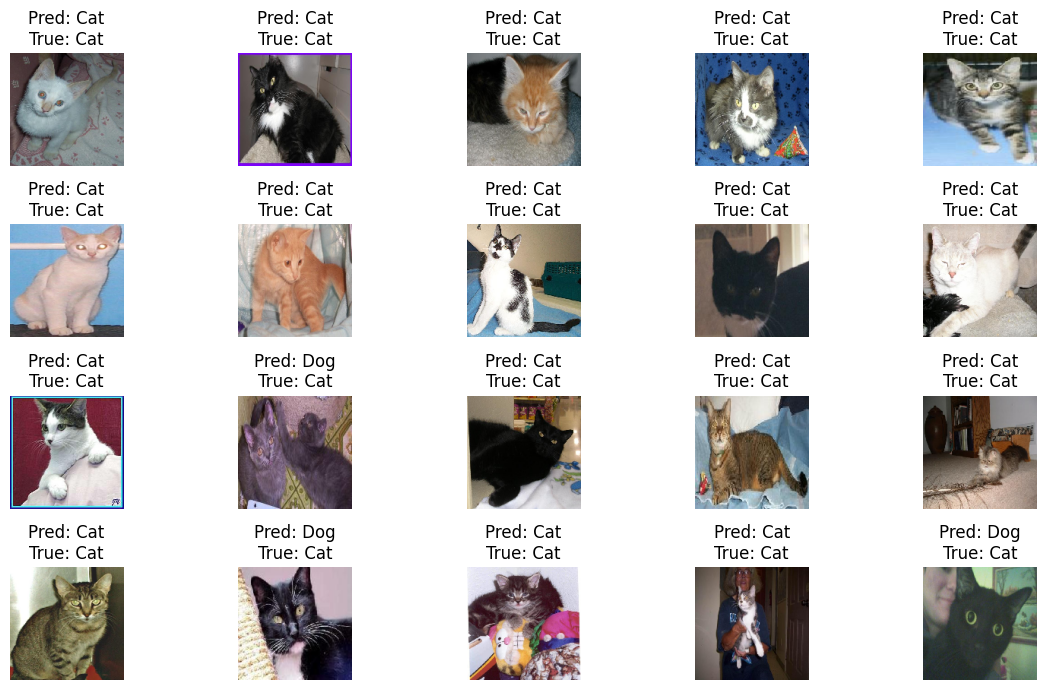

In [62]:
plt.figure(figsize=(12, 7))
for i in range(20):
    img, label = test_generator[i][0][0], test_generator[i][1][0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    pred_label = 'Dog' if pred[i] else 'Cat'
    true_label = 'Dog' if true_labels[i] else 'Cat'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [63]:
mistakes = np.where(pred != true_labels)[0]

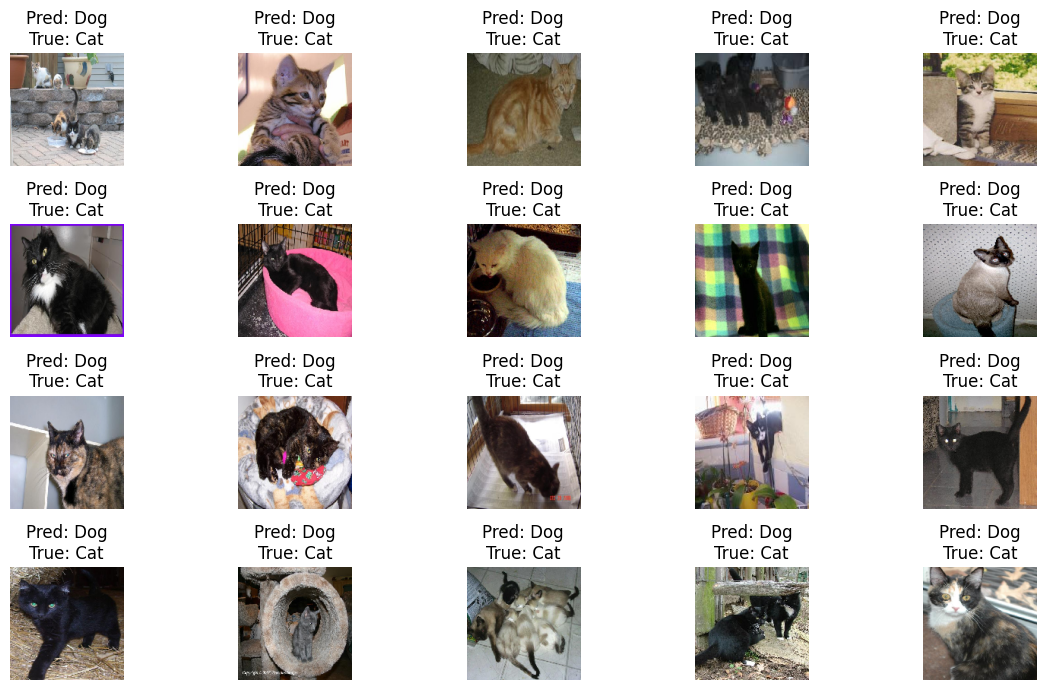

In [64]:
plt.figure(figsize=(12, 7))
for n, idx in enumerate(mistakes[:20]):
    img, label = test_generator[idx // batch_size][0][idx % batch_size], test_generator[idx // batch_size][1][idx % batch_size]
    plt.subplot(4, 5, n + 1)
    plt.imshow(img)
    pred_label = 'Dog' if pred[idx] else 'Cat'
    true_label = 'Dog' if true_labels[idx] else 'Cat'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()